In [1]:
# CS598 Deep Learning for Healthcare
# CaliForest - My Extension
# Grant Espe

In [2]:
# Imports
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.linear_model import LogisticRegression as LR
from sklearn.isotonic import IsotonicRegression as Iso
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import numpy as np
import pandas as pd
import pickle


In [3]:
# Load the CaliForest Class - https://github.com/yubin-park/califorest/blob/master/califorest/califorest.py

class CaliForest(ClassifierMixin, BaseEstimator):
    def __init__(self,
                n_estimators=300,
                criterion="gini",
                max_depth=5,
                min_samples_split=2,
                min_samples_leaf=1,
                ctype="isotonic",
                alpha0=100,
                beta0=25):

        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.ctype = ctype
        self.alpha0 = alpha0
        self.beta0 = beta0

    
    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=False)
        self.estimators = []
        self.calibrator = None
        for i in range(self.n_estimators):
            self.estimators.append(Tree(criterion=self.criterion,
                                        max_depth=self.max_depth,
                                        min_samples_split=self.min_samples_split,
                                        min_samples_leaf=self.min_samples_leaf,
                                      #  max_features="auto")) failing on newer version of DecisionTreeClassifier
                                        max_features="sqrt"))

        if self.ctype=="logistic":
            #self.calibrator = LR(penalty="none", #Changed from 'none' -> None
            self.calibrator = LR(penalty=None,
                                 solver="saga",
                                 max_iter=5000)
        elif self.ctype=="isotonic":
            self.calibrator = Iso(y_min=0,
                                y_max=1,
                                out_of_bounds="clip")
        n, m  = X.shape
        Y_oob = np.full((n, self.n_estimators), np.nan)
        n_oob = np.zeros(n)
        IB = np.zeros((n, self.n_estimators), dtype=int)
        OOB = np.full((n, self.n_estimators), True)
        
        for eid in range(self.n_estimators):
            IB[:,eid] = np.random.choice(n, n)
            OOB[IB[:,eid],eid] = False

        for eid, est in enumerate(self.estimators):
            ib_idx = IB[:,eid]
            oob_idx = OOB[:,eid]
            est.fit(X[ib_idx,:], y[ib_idx])
            Y_oob[oob_idx,eid] = est.predict_proba(X[oob_idx,:])[:,1]
            n_oob[oob_idx] += 1


        oob_idx = n_oob > 1
        Y_oob_ = Y_oob[oob_idx,:]
        n_oob_ = n_oob[oob_idx]
        z_hat = np.nanmean(Y_oob_, axis=1)
        z_true = y[oob_idx]

        beta = self.beta0 + np.nanvar(Y_oob_, axis=1) * n_oob_ / 2
        alpha = self.alpha0 + n_oob_/2
        z_weight = alpha / beta

        if self.ctype=="logistic":
            self.calibrator.fit(z_hat[:,np.newaxis], z_true, z_weight)
        elif self.ctype=="isotonic":
            self.calibrator.fit(z_hat, z_true, z_weight)
        self.is_fitted_ = True
        return self

    
    def predict_proba(self, X):
        X = check_array(X)
        check_is_fitted(self, 'is_fitted_')
        
        n, m = X.shape
        n_est = len(self.estimators)
        z = np.zeros(n)
        y_mat = np.zeros((n,2))
        for eid, est in enumerate(self.estimators):
            z += est.predict_proba(X)[:,1]
        z /= n_est

        if self.ctype=="logistic":
            y_mat[:,1] = self.calibrator.predict_proba(z[:,np.newaxis])[:,1]
        elif self.ctype=="isotonic":
            y_mat[:,1] = self.calibrator.predict(z)
            
        y_mat[:,0] = 1 - y_mat[:,1]
        return y_mat


    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [4]:
# Load the RC30 Class - https://github.com/yubin-park/califorest/blob/master/califorest/rc30.py

class RC30(ClassifierMixin, BaseEstimator):

    def __init__(self, 
                n_estimators=30, 
                max_depth=3,
                min_samples_split=2,
                min_samples_leaf=1, 
                ctype="isotonic"):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.ctype = ctype

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.model = RandomForestClassifier(n_estimators=self.n_estimators,
                                            max_depth=self.max_depth,
                                            min_samples_split=self.min_samples_split,
                                            min_samples_leaf=self.min_samples_leaf)
        if self.ctype == "logistic":
            self.calibrator = LR(C=1e20, solver="lbfgs")
        elif self.ctype == "isotonic":
            self.calibrator = Iso(y_min=0, y_max=1,
                                                out_of_bounds="clip")
        X0, X1, y0, y1 = train_test_split(X, y, test_size=0.3) 
        self.model.fit(X0, y0)
        if self.ctype == "logistic":
            y_est = self.model.predict_proba(X1)[:,[1]]
            self.calibrator.fit(y_est, y1)
        elif self.ctype == "isotonic":
            y_est = self.model.predict_proba(X1)[:,1]
            self.calibrator.fit(y_est, y1)

        self.is_fitted_ = True
        return self
 
    def predict_proba(self, X):
        X = check_array(X)
        check_is_fitted(self, 'is_fitted_')
        
        if self.ctype == "logistic":
            return self.calibrator.predict_proba(
                    self.model.predict_proba(X)[:,[1]])
        elif self.ctype == "isotonic":
            n, m = X.shape
            y = np.zeros((n,2))
            y[:,1] = self.calibrator.predict(
                        self.model.predict_proba(X)[:,1])
            y[:,0] = 1 - y[:,1]
            return y




In [5]:
# Load CaliForest Evaluation Metrics - https://github.com/yubin-park/califorest/blob/master/califorest/metrics/eval_metrics.py

import sklearn.metrics as skm
from scipy.stats import chi2
from scipy.stats import norm

def hosmer_lemeshow(y_true, y_score):
    """
    Calculate the Hosmer Lemeshow to assess whether
    or not the observed event rates match expected
    event rates.

    Assume that there are 10 groups:
    HL = \\sum_{g=1}^G \\frac{(O_{1g} - E_{1g})^2}{N_g \\pi_g (1- \\pi_g)}
    """
    n_grp = 10 # number of groups

    # create the dataframe
    df = pd.DataFrame({'score': y_score, 'target': y_true})

    # sort the values
    df = df.sort_values('score')
    # shift the score a bit
    df['score'] = np.clip(df['score'], 1e-8, 1-1e-8)
    df['rank'] = list(range(df.shape[0]))
    # cut them into 10 bins
    df['score_decile'] = pd.qcut(df['rank'], n_grp,
                                      duplicates='raise')
    # sum up based on each decile
    obsPos = df['target'].groupby(df.score_decile).sum()
    obsNeg = (df['target'].groupby(df.score_decile).count() - 
                obsPos)
    exPos = df['score'].groupby(df.score_decile).sum()
    exNeg = df['score'].groupby(df.score_decile).count() - exPos
    hl = (((obsPos - exPos)**2/exPos) + ((obsNeg - exNeg)**2/exNeg)).sum()

    # https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test
    # Re: p-value, higher the better Goodness-of-Fit
    p_value = 1 - chi2.cdf(hl, n_grp-2)
    
    return p_value

def reliability(y_true, y_score):

    n_grp = 10
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values('score')
    df['rank'] = list(range(df.shape[0]))
    df['score_decile'] = pd.qcut(df['rank'], n_grp,
                                      duplicates='raise')

    obs = df['target'].groupby(df.score_decile).mean()
    exp = df['score'].groupby(df.score_decile).mean()

    rel_small = np.mean((obs - exp)**2)
    rel_large = (np.mean(y_true) - np.mean(y_score))**2

    return rel_small, rel_large

def spiegelhalter(y_true, y_score):
    top = np.sum((y_true - y_score)*(1-2*y_score))
    bot = np.sum((1-2*y_score)**2 * y_score * (1-y_score))
    sh = top / np.sqrt(bot)

    # https://en.wikipedia.org/wiki/Z-test
    # Two-tailed test
    # Re: p-value, higher the better Goodness-of-Fit
    p_value = norm.sf(np.abs(sh)) * 2

    return p_value

def scaled_brier_score(y_true, y_score):
    brier = skm.brier_score_loss(y_true, y_score)
    # calculate the mean of the probability
    p = np.mean(y_true)  
    brier_scaled = 1 - brier / (p * (1-p))
    return brier, brier_scaled


In [6]:
# Helper Functions for Loading MIMIC-Extract Dataset - https://github.com/yubin-park/califorest/blob/master/analysis/mimic_extract.py

GAP_TIME          = 6  # In hours
WINDOW_SIZE       = 24 # In hours
ID_COLS           = ['subject_id', 'hadm_id', 'icustay_id']
TRAIN_FRAC, TEST_FRAC = 0.7, 0.3

def simple_imputer(df):
    idx = pd.IndexSlice
    df = df.copy()
    if len(df.columns.names) > 2: 
        df.columns = df.columns.droplevel(('label', 'LEVEL1', 'LEVEL2'))
    
    df_out = df.loc[:, idx[:, ['mean', 'count']]]
    
    icustay_means = df_out.loc[:, idx[:, 'mean']].groupby(ID_COLS).mean()
    imputed_means = (df_out.loc[:,idx[:,'mean']]
                           .groupby(ID_COLS).fillna(method='ffill')
                           .groupby(ID_COLS).fillna(icustay_means)
                           .fillna(0)).copy()
    df_out.loc[:,idx[:,'mean']] = imputed_means

    mask = (df.loc[:, idx[:,'count']] > 0).astype(float).copy()
    df_out.loc[:,idx[:,'count']] = mask
    df_out = df_out.rename(columns={'count': 'mask'}, 
                            level='Aggregation Function')
   
    is_absent = (1 - df_out.loc[:, idx[:,'mask']].copy())
    hours_of_absence = is_absent.cumsum()
    time_since_measured = (hours_of_absence 
                           - (hours_of_absence[is_absent==0]
                                .fillna(method='ffill')))
    time_since_measured.rename(columns={'mask': 'time_since_measured'}, 
                               level='Aggregation Function', 
                               inplace=True)

    df_out = pd.concat((df_out, time_since_measured), axis=1)
    time_since_measured = (df_out.loc[:, idx[:, 'time_since_measured']]
                                .fillna(WINDOW_SIZE+1)).copy()
    df_out.loc[:, idx[:, 'time_since_measured']] = time_since_measured
    df_out.sort_index(axis=1, inplace=True)
    return df_out

def mimic_extract(random_seed, target):

    statics = pd.read_hdf("../data/all_hourly_data.h5", 'patients')
    data_full_lvl2 = pd.read_hdf("../data/all_hourly_data.h5", 'vitals_labs')

    statics = statics[statics.max_hours > WINDOW_SIZE + GAP_TIME]
    Ys = statics.loc[:,['mort_hosp', 'mort_icu', 'los_icu']]
    Ys.loc[:,"mort_hosp"] = (Ys.loc[:,"mort_hosp"]).astype(int)
    Ys.loc[:,"mort_icu"] = (Ys.loc[:,"mort_icu"]).astype(int)
    Ys.loc[:,'los_3'] = (Ys.loc[:,'los_icu'] > 3).astype(int)
    Ys.loc[:,'los_7'] = (Ys.loc[:,'los_icu'] > 7).astype(int)
    Ys.drop(columns=['los_icu'], inplace=True)

    lvl2 = data_full_lvl2.loc[(data_full_lvl2
                    .index.get_level_values('icustay_id')
                    .isin(set(Ys.index.get_level_values('icustay_id')))) &
                (data_full_lvl2
                    .index.get_level_values('hours_in') < WINDOW_SIZE),:] 

    lvl2_subj_idx, Ys_subj_idx = [df.index.get_level_values('subject_id') 
                                    for df in (lvl2, Ys)]
    lvl2_subjects = set(lvl2_subj_idx)
    assert lvl2_subjects == set(Ys_subj_idx), "Subject ID pools differ!"

    np.random.seed(random_seed)
    subjects = np.random.permutation(list(lvl2_subjects))
    N = len(lvl2_subjects)
    N_train, N_test = int(TRAIN_FRAC * N), int(TEST_FRAC * N)
    train_subj = subjects[:N_train]
    test_subj  = subjects[N_train:]

    [(lvl2_train, lvl2_test), (Ys_train, Ys_test)] = [
        [df.loc[df.index.get_level_values('subject_id').isin(s),:] 
            for s in (train_subj, test_subj)] for df in (lvl2, Ys)]

    idx = pd.IndexSlice
    lvl2_means = lvl2_train.loc[:,idx[:,'mean']].mean(axis=0)

    # here, we do not use the standard deviation. 
    # Tree models do not get affected by the scale of values.
    lvl2_stds = lvl2_train.loc[:,idx[:,'mean']].std(axis=0)

    vals_centered = (lvl2_train.loc[:,idx[:,'mean']] - lvl2_means)
    lvl2_train.loc[:,idx[:,'mean']] = vals_centered
    vals_centered = (lvl2_test.loc[:,idx[:,'mean']] - lvl2_means)
    lvl2_test.loc[:,idx[:,'mean']] = vals_centered

    lvl2_train, lvl2_test = [simple_imputer(df) 
                                for df in (lvl2_train, lvl2_test)]

    lvl2_flat_train, lvl2_flat_test = [(df
                .pivot_table(index=['subject_id', 'hadm_id', 'icustay_id'], 
                                               columns=['hours_in'])) 
                                   for df in (lvl2_train, lvl2_test)]
    

    return (lvl2_flat_train.values, 
            lvl2_flat_test.values,
            Ys_train.loc[:,target].values,
            Ys_test.loc[:,target].values)



In [7]:
import csv
from pprint import pprint
import time
from itertools import product
from sklearn.datasets import make_hastie_10_2
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures

def read_data(dataset, random_seed):

    X_train, X_test, y_train, y_test = None, None, None, None
    
    if dataset == "hastie":
        np.random.seed(random_seed)
        poly = PolynomialFeatures()
        X, y = make_hastie_10_2(n_samples=10000)
        X = poly.fit_transform(X)
        y[y<0] = 0
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)
    elif dataset == "breast_cancer":
        np.random.seed(random_seed)
        poly = PolynomialFeatures()
        X, y = load_breast_cancer(return_X_y=True)
        X = poly.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3)
    elif dataset == "mimic3_mort_hosp":
        X_train, X_test, y_train, y_test = mimic_extract(random_seed, 
                                                        "mort_hosp")
    elif dataset == "mimic3_mort_icu":
        X_train, X_test, y_train, y_test = mimic_extract(random_seed, 
                                                        "mort_icu")
    elif dataset == "mimic3_los_3":
        X_train, X_test, y_train, y_test = mimic_extract(random_seed, 
                                                        "los_3")
    elif dataset == "mimic3_los_7":
        X_train, X_test, y_train, y_test = mimic_extract(random_seed, 
                                                        "los_7")
 
    return X_train, X_test, y_train, y_test

def init_models(n_estimators, max_depth):

    mss = 3
    msl = 1
    models = {"CF-Iso": CaliForest(n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_split=mss,
                                        min_samples_leaf=msl,
                                        ctype="isotonic")}
    return models


def run(dataset, random_seed, n_estimators=300, depth=10):

    X_train, X_test, y_train, y_test = read_data(dataset, random_seed)

    output = []

    models = init_models(n_estimators, depth)
 
    for name, model in models.items():
        t_start = time.time()
        model.fit(X_train, y_train)
        t_elapsed = time.time() - t_start
        y_pred = model.predict_proba(X_test)[:,1]

        score_auc = roc_auc_score(y_test, y_pred)
        score_hl = hosmer_lemeshow(y_test, y_pred)
        score_sh = spiegelhalter(y_test, y_pred)
        score_b, score_bs = scaled_brier_score(y_test, y_pred)
        rel_small, rel_large = reliability(y_test, y_pred)

        row = [dataset, name, random_seed, 
               score_auc, score_b, score_bs, score_hl, score_sh,
               rel_small, rel_large] 

        print(("[info] {} {}: {:.3f} sec & BS {:.5f}").format(
                dataset, name, t_elapsed, score_b))

        output.append(row)

    return output

In [8]:
# EDIT THIS CELL FOR CHANGING DATASET AND HYPERPARAMETERS       

if __name__ == "__main__":

    output = [["n_estimators", "dataset", "model", 
                "random_seed", "auc", "brier", "brier_scaled", 
                "hosmer_lemshow", "speigelhalter",
                "reliability_small", "reliability_large"]]
   
    dataset = "hastie"
    #dataset = "breast_cancer"

    # Adjust the number of estimators and depth of trees
    minimum_estimators = 10
    maximum_estimators = 500
    step = 25
    d = 10

    for n in range(minimum_estimators, maximum_estimators, step):
        for rs in range(10):
            #output += run(args.dataset, rs)
            result = run(dataset, rs, n_estimators=n, depth=d)
            result[0] = [n] + result[0]
            output += result
        print(f"Finished n_estimators = {n}")
            

    fn = "results/{}.csv".format(dataset)
    with open(fn, "w") as fp:
        writer = csv.writer(fp)
        writer.writerows(output)

[info] hastie CF-Iso: 0.422 sec & BS 0.10196
[info] hastie CF-Iso: 0.415 sec & BS 0.10082
[info] hastie CF-Iso: 0.418 sec & BS 0.10273
[info] hastie CF-Iso: 0.414 sec & BS 0.10563
[info] hastie CF-Iso: 0.419 sec & BS 0.09728
[info] hastie CF-Iso: 0.424 sec & BS 0.10042
[info] hastie CF-Iso: 0.416 sec & BS 0.10016
[info] hastie CF-Iso: 0.415 sec & BS 0.09312
[info] hastie CF-Iso: 0.416 sec & BS 0.09793
[info] hastie CF-Iso: 0.412 sec & BS 0.09685
Finished n_estimators = 10
[info] hastie CF-Iso: 1.465 sec & BS 0.06963
[info] hastie CF-Iso: 1.462 sec & BS 0.06771
[info] hastie CF-Iso: 1.459 sec & BS 0.06998
[info] hastie CF-Iso: 1.459 sec & BS 0.06807
[info] hastie CF-Iso: 1.444 sec & BS 0.06437
[info] hastie CF-Iso: 1.463 sec & BS 0.06897
[info] hastie CF-Iso: 1.455 sec & BS 0.06342
[info] hastie CF-Iso: 1.448 sec & BS 0.06788
[info] hastie CF-Iso: 1.458 sec & BS 0.06641
[info] hastie CF-Iso: 1.457 sec & BS 0.06465
Finished n_estimators = 35
[info] hastie CF-Iso: 2.509 sec & BS 0.06286
[

<Figure size 700x400 with 0 Axes>

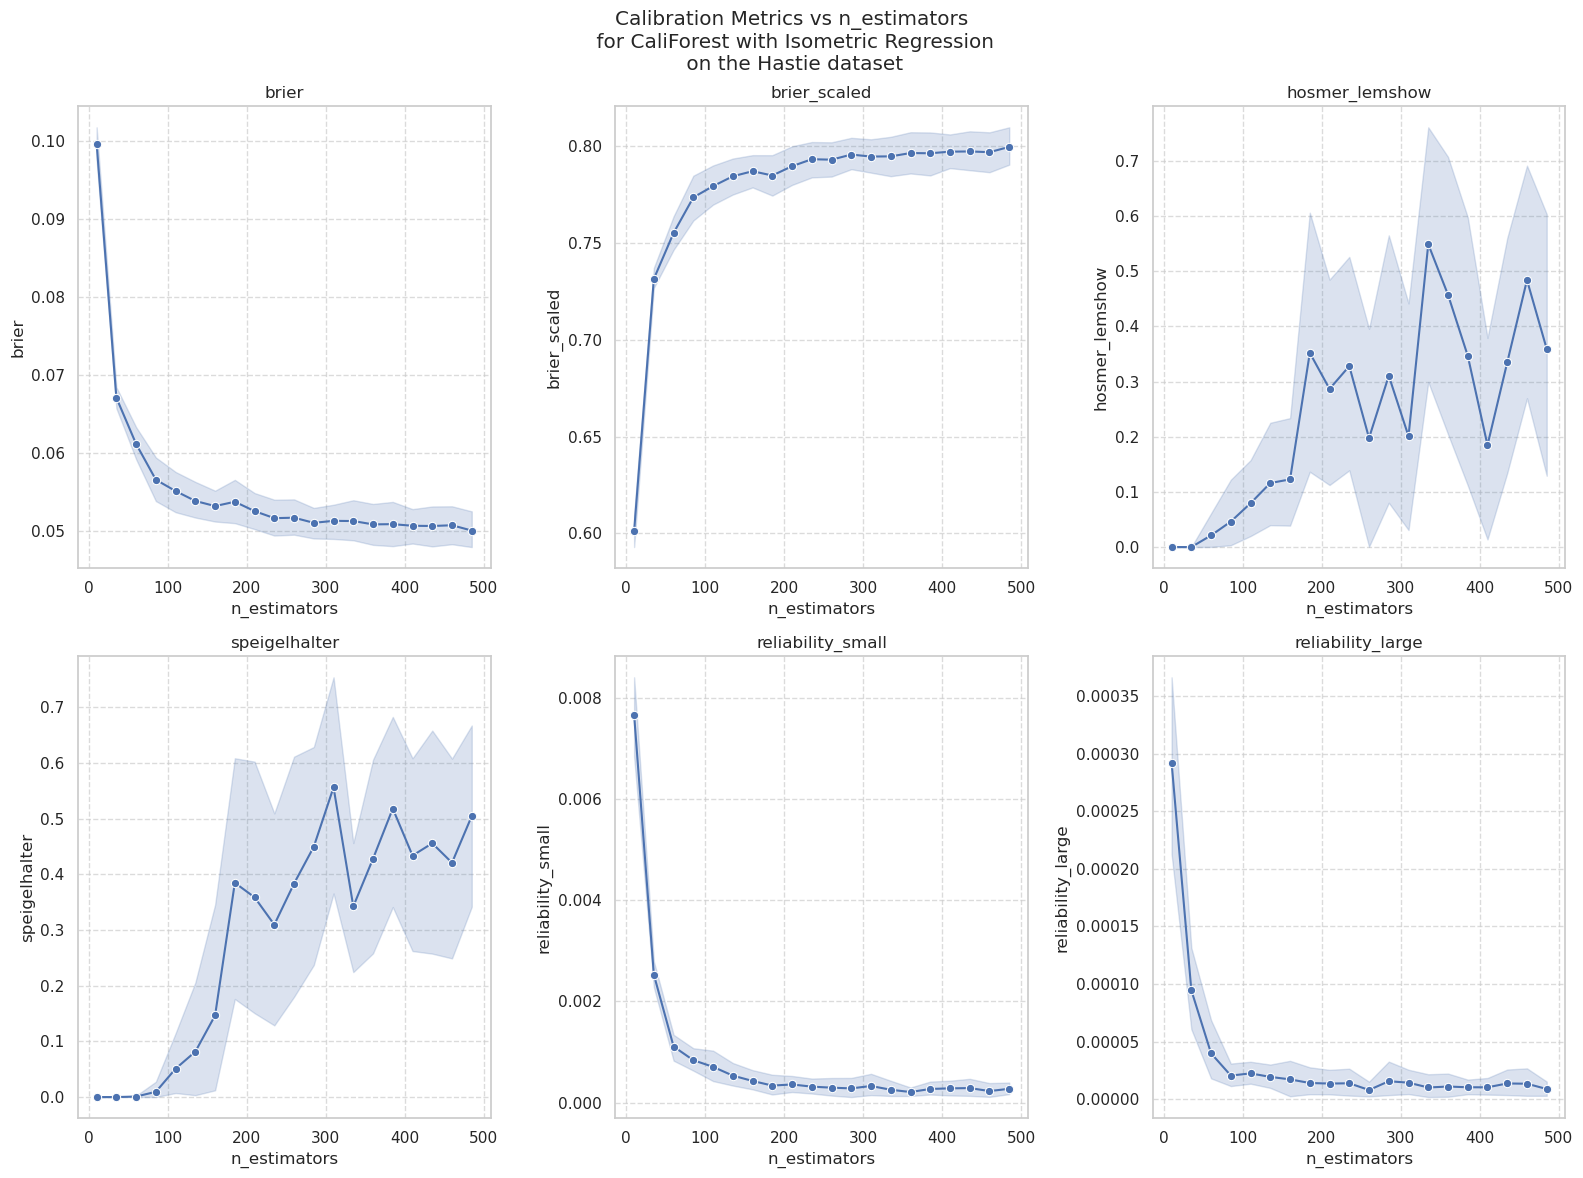

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
dataset = "hastie"

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 4))

df = pd.read_csv(f'results/{dataset}.csv')
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.flatten()

metrics = ['brier', 'brier_scaled', 'hosmer_lemshow', 'speigelhalter', 'reliability_small', 'reliability_large']

#plot subplots
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=df,
        x='n_estimators',
        y=metric,
        marker='o',
        ax=axes[i]
    )
    axes[i].set_xlabel('n_estimators')
    axes[i].set_title(metric)
    axes[i].grid(True, linestyle='--', alpha=0.7)#gridlines
fig.suptitle("Calibration Metrics vs n_estimators\n for CaliForest with Isometric Regression\n on the Hastie dataset")
plt.tight_layout()
plt.show()
fig.savefig(f'results/{dataset}_n_estimators.png')
